# Problem statement: To Predict the Prices of private residential properties.

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import re
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import metrics,linear_model
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression,Lasso

In [2]:
house1 = pd.read_csv('./dataset_asof_051121/house1.csv',skiprows = [0])
house2 = pd.read_csv('./dataset_asof_051121/house2.csv',skiprows = [0])
house3 = pd.read_csv('./dataset_asof_051121/house3.csv',skiprows = [0])
house4 = pd.read_csv('./dataset_asof_051121/house4.csv',skiprows = [0])
house5 = pd.read_csv('./dataset_asof_051121/house5.csv',skiprows = [0])
house6 = pd.read_csv('./dataset_asof_051121/house6.csv',skiprows = [0])

## Looking at the house data set an dnumber of rows

In [3]:
print(house1.shape)
print(house2.shape)
print(house3.shape)
print(house4.shape)
print(house5.shape)
print(house6.shape)

(305, 16)
(883, 16)
(2578, 16)
(3370, 16)
(1595, 16)
(1084, 16)


In [4]:
house1.dtypes

S/N                   object
Project Name          object
Street Name           object
Type                  object
Postal District      float64
Market Segment        object
Tenure                object
Type of Sale          object
No. of Units         float64
Price ($)            float64
Nett Price ($)        object
Area (Sqft)          float64
Type of Area          object
Floor Level           object
Unit Price ($psf)    float64
Date of Sale          object
dtype: object

## Cleaning of data and objects rows
## It was noticed that alot of the base of each csv has text with NaN

In [5]:
house1.dropna(axis = 0, inplace = True)
house2.dropna(axis = 0, inplace = True)
house3.dropna(axis = 0, inplace = True)
house4.dropna(axis = 0, inplace = True)
house5.dropna(axis = 0, inplace = True)
house6.dropna(axis = 0, inplace = True)

In [6]:
house1.shape

(291, 16)

In [7]:
house1.head(1)

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
0,1,LANDED HOUSING DEVELOPMENT,PASIR PANJANG DRIVE,Terrace,5.0,RCR,Freehold,Resale,1.0,3660000.0,-,2566.0,Land,-,1426.0,Oct-2021


In [8]:
house1.tail(1)

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
290,291,CHWEE CHIAN VIEW,CHWEE CHIAN VIEW,Terrace,5.0,RCR,Freehold,Resale,1.0,2310000.0,-,1803.0,Land,-,1281.0,Nov-2016


## Data exploration and merging of data

In [9]:
house1.isnull().sum()

S/N                  0
Project Name         0
Street Name          0
Type                 0
Postal District      0
Market Segment       0
Tenure               0
Type of Sale         0
No. of Units         0
Price ($)            0
Nett Price ($)       0
Area (Sqft)          0
Type of Area         0
Floor Level          0
Unit Price ($psf)    0
Date of Sale         0
dtype: int64

In [10]:
merged_house = pd.concat([house1, house2, house3, house4, house5, house6])

In [11]:
merged_house.reset_index(drop = True, inplace = True)

In [12]:
merged_house.drop(['S/N'], axis=1, inplace = True)

In [13]:
merged_house.shape

(9728, 15)

In [14]:
merged_house.tail()

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
9723,MIMOSA TERRACE,MIMOSA VIEW,Terrace,28.0,OCR,Freehold,Resale,1.0,2330000.0,-,1616.0,Land,-,1442.0,Nov-2016
9724,SARACA VILLAS,SARACA TERRACE,Terrace,28.0,OCR,99 yrs lease commencing from 1997,Resale,1.0,1675000.0,-,2410.0,Land,-,695.0,Nov-2016
9725,GERALD GARDENS,GERALD CRESCENT,Terrace,28.0,OCR,999 yrs lease commencing from 1879,Resale,1.0,2980000.0,-,4192.0,Land,-,711.0,Nov-2016
9726,LANDED HOUSING DEVELOPMENT,JALAN SANKAM,Semi-detached,27.0,OCR,Freehold,Resale,1.0,1750000.0,-,2099.0,Land,-,834.0,Nov-2016
9727,LANDED HOUSING DEVELOPMENT,NIM ROAD,Detached,28.0,OCR,Freehold,Resale,1.0,10300000.0,-,9955.0,Land,-,1035.0,Nov-2016


In [15]:
merged_house.reset_index(drop = False , inplace = True)

In [16]:
merged_house.tail()

,index,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
9723,9723,MIMOSA TERRACE,MIMOSA VIEW,Terrace,28.0,OCR,Freehold,Resale,1.0,2330000.0,-,1616.0,Land,-,1442.0,Nov-2016
9724,9724,SARACA VILLAS,SARACA TERRACE,Terrace,28.0,OCR,99 yrs lease commencing from 1997,Resale,1.0,1675000.0,-,2410.0,Land,-,695.0,Nov-2016
9725,9725,GERALD GARDENS,GERALD CRESCENT,Terrace,28.0,OCR,999 yrs lease commencing from 1879,Resale,1.0,2980000.0,-,4192.0,Land,-,711.0,Nov-2016
9726,9726,LANDED HOUSING DEVELOPMENT,JALAN SANKAM,Semi-detached,27.0,OCR,Freehold,Resale,1.0,1750000.0,-,2099.0,Land,-,834.0,Nov-2016
9727,9727,LANDED HOUSING DEVELOPMENT,NIM ROAD,Detached,28.0,OCR,Freehold,Resale,1.0,10300000.0,-,9955.0,Land,-,1035.0,Nov-2016


## Renaming columns in the dataframe for easy typing

In [17]:
merged_house.rename(columns = {"Price ($)":"Price", "Nett Price ($)": "Nett Price", "Area (Sqft)": "Areasq", 
                               "Unit Price ($psf)": "Unit Price psf"}, inplace = True)

In [18]:
merged_house.head(1)

,index,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price,Nett Price,Areasq,Type of Area,Floor Level,Unit Price psf,Date of Sale
0,0,LANDED HOUSING DEVELOPMENT,PASIR PANJANG DRIVE,Terrace,5.0,RCR,Freehold,Resale,1.0,3660000.0,-,2566.0,Land,-,1426.0,Oct-2021


In [19]:
merged_house.columns = merged_house.columns.str.lower()

### Saving dataframe

In [20]:
merged_house.to_csv('./dataset_asof_051121/merged_house.csv', index=False)

In [21]:
merged_house.head()

,index,project name,street name,type,postal district,market segment,tenure,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
0,0,LANDED HOUSING DEVELOPMENT,PASIR PANJANG DRIVE,Terrace,5.0,RCR,Freehold,Resale,1.0,3660000.0,-,2566.0,Land,-,1426.0,Oct-2021
1,1,OCEAN 8,OCEAN DRIVE,Terrace,4.0,CCR,99 yrs lease commencing from 2005,Resale,1.0,6920000.0,-,3852.0,Land,-,1796.0,Oct-2021
2,2,LANDED HOUSING DEVELOPMENT,OCEAN DRIVE,Detached,4.0,CCR,99 yrs lease commencing from 2005,Resale,1.0,17888000.0,-,8746.0,Land,-,2045.0,Oct-2021
3,3,WEST COAST GARDENS,WEST COAST PARK,Semi-detached,5.0,OCR,956 yrs lease commencing from 1928,Resale,1.0,5400000.0,-,4806.0,Land,-,1124.0,Oct-2021
4,4,LANDED HOUSING DEVELOPMENT,JALAN MAS KUNING,Terrace,5.0,OCR,Freehold,Resale,1.0,2660000.0,-,1640.0,Land,-,1622.0,Oct-2021


### Data Exploration

### 417 types of project name

In [22]:
merged_house['project name'].value_counts()

LANDED HOUSING DEVELOPMENT    3923
SERANGOON GARDEN ESTATE        465
SELETAR HILLS ESTATE           242
OPERA ESTATE                   210
SEMBAWANG HILLS ESTATE         194
                              ... 
CHUAN VALE                       1
THE SILVA GARDENS                1
ONE SURIN                        1
PROSPECT GARDEN                  1
SEMBAWANG SQUARE ESTATE          1
Name: project name, Length: 471, dtype: int64

### Region of the houses

In [23]:
merged_house['market segment'].value_counts()

OCR    6555
RCR    1789
CCR    1384
Name: market segment, dtype: int64

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


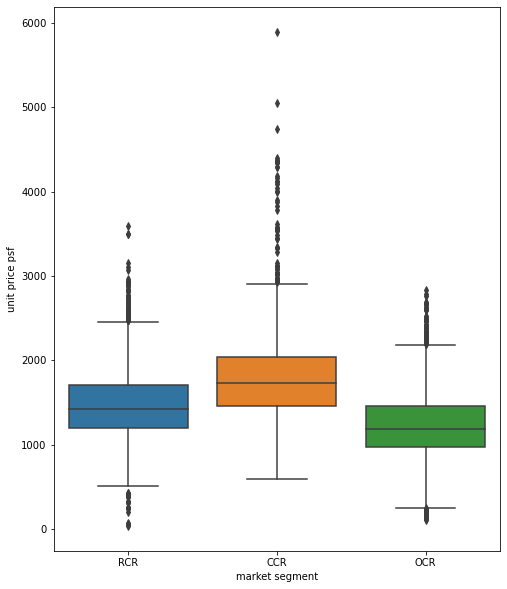

In [24]:
plt.figure(figsize =(8,10))
ax = sns.boxplot('market segment', 'unit price psf', data = merged_house);

### District of houses

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


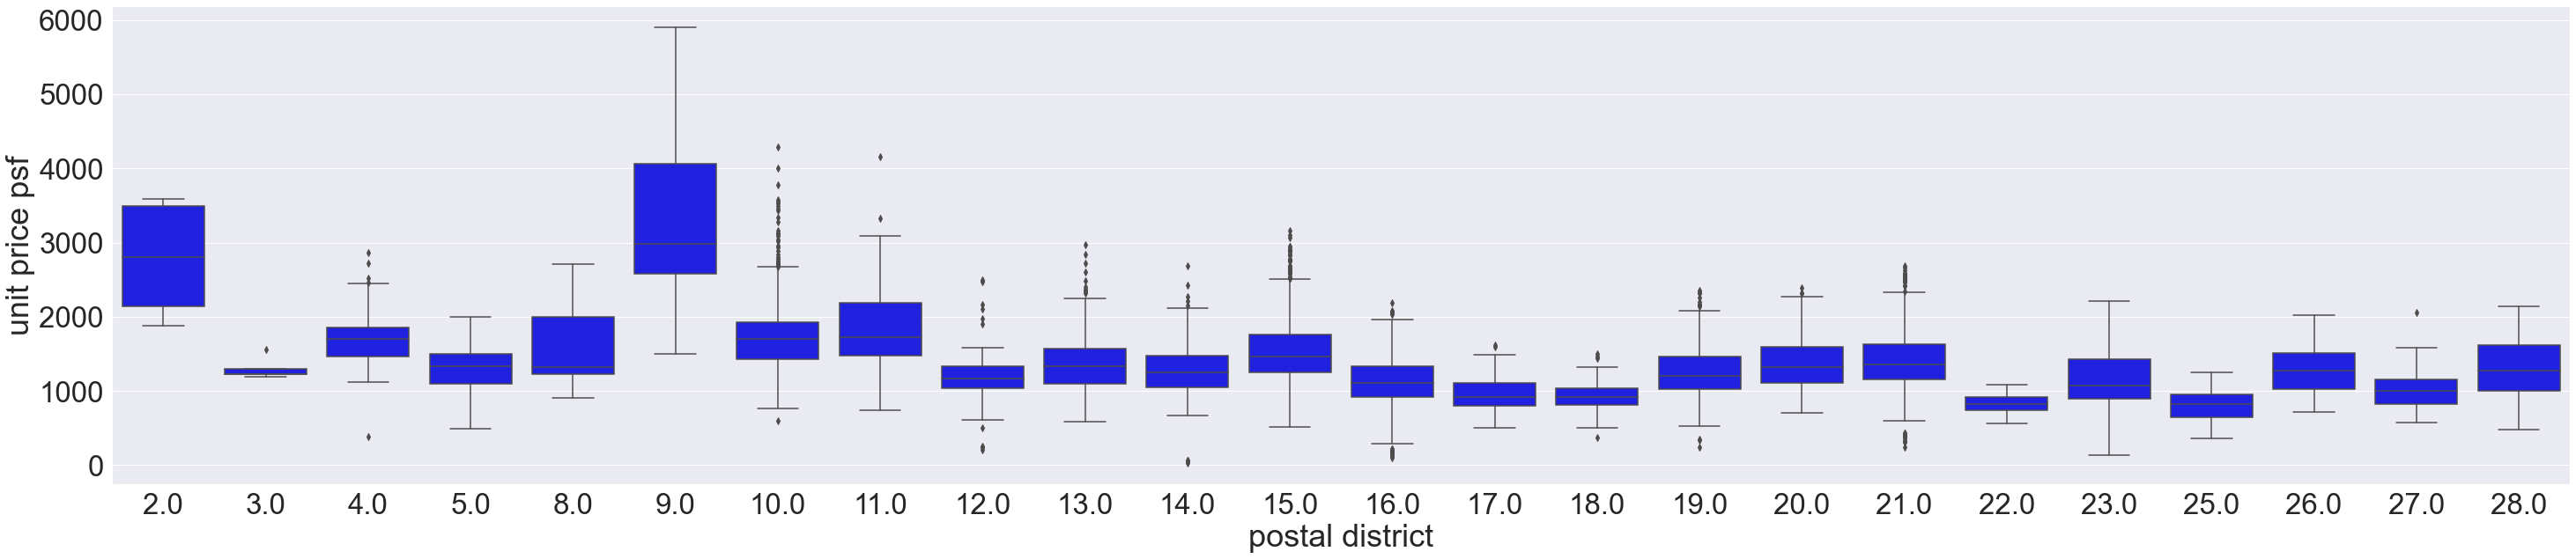

In [25]:
sns.set(font_scale=3)
plt.figure(figsize =(50,10))
district_place = sns.boxplot('postal district', 'unit price psf', data = merged_house, color ='blue');

In [26]:
merged_house['price'].value_counts()

3000000.0     159
2800000.0     143
3500000.0     108
2600000.0     105
2500000.0     103
             ... 
6168000.0       1
36882500.0      1
8738000.0       1
2398888.0       1
3398888.0       1
Name: price, Length: 1892, dtype: int64

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


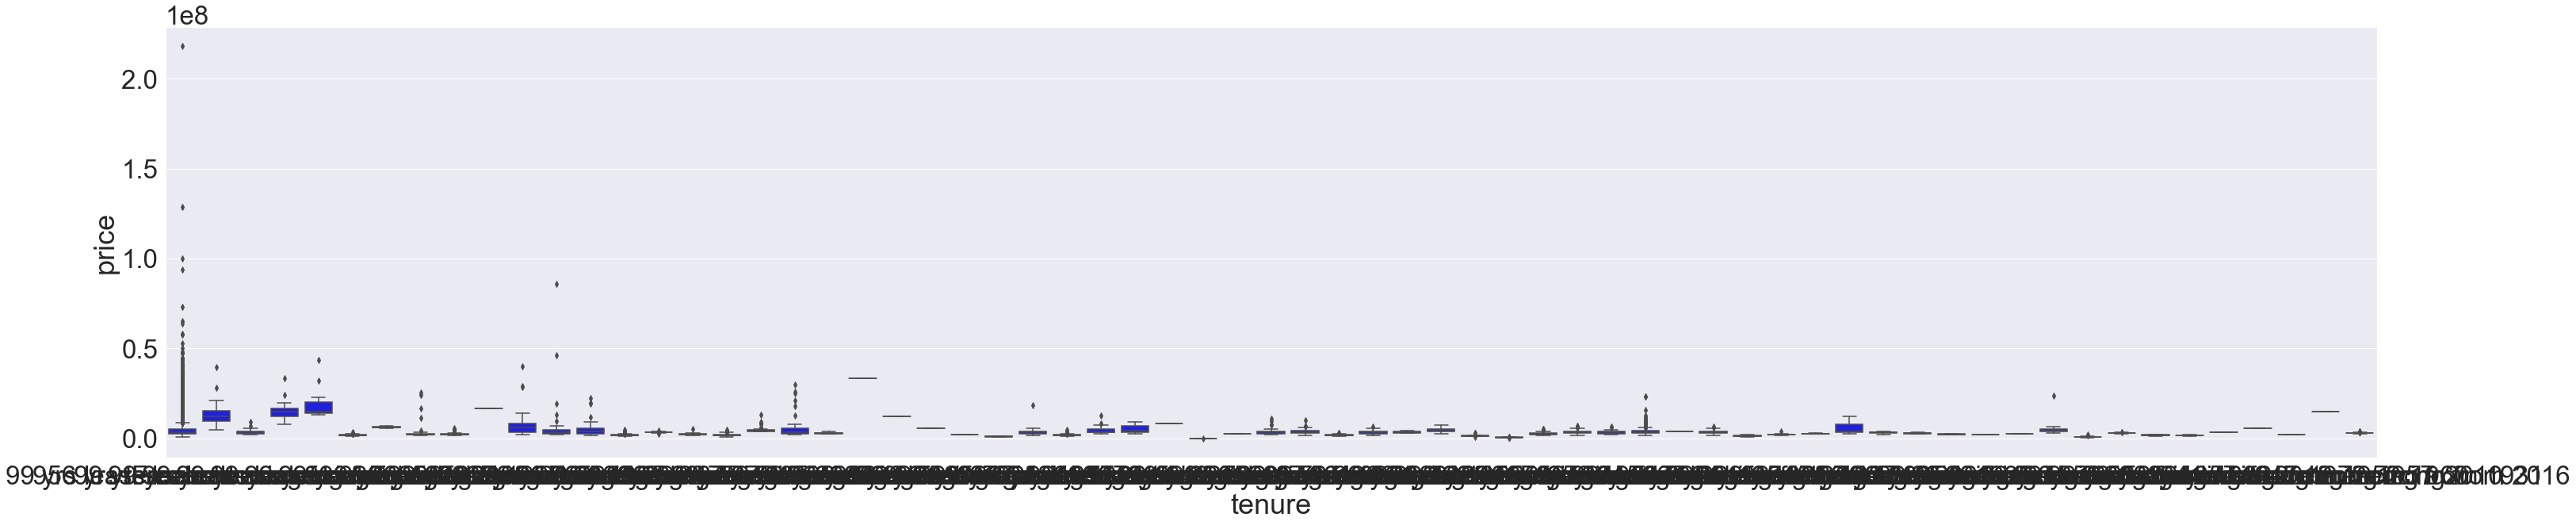

In [27]:
sns.set(font_scale=3)
plt.figure(figsize =(50,10))
type_of_hold = sns.boxplot('tenure', 'price', data = merged_house, color ='blue');

### Cleaning of the tenure is column is required

In [28]:
merged_house['tenure'].value_counts().head()

Freehold                              6480
999 yrs lease commencing from 1879     491
99 yrs lease commencing from 1994      309
99 yrs lease commencing from 1996      183
99 yrs lease commencing from 1997      178
Name: tenure, dtype: int64

In [29]:
merged_house['tenure'].nunique()

65

In [30]:
tenure_list = merged_house['tenure']

In [31]:
tenure_list = merged_house['tenure']
tenure_split = tenure_list.str.split()[0]

Taking out the 1st word from tenure and replace freehold with 999
Taking out the last word from tenure, since freehold is also the last word for freehold, change it to 999

In [32]:
first = merged_house['tenure'].str.split().str[0]
last = merged_house['tenure'].str.split().str[-1]

In [33]:
first.replace({'Freehold':999}, inplace = True)
last.replace({'Freehold':999}, inplace = True)

In [34]:
first = first.astype(int)
last = last.astype(int)

In [35]:
tenure = first + last - 2021
tenure.replace({-23:999}, inplace = True)

In [36]:
tenure.head()

0    999
1     83
2     83
3    863
4    999
Name: tenure, dtype: int64

Drop original tenure and inplace the cleaned data tenure

In [37]:
merged_house.drop(columns = 'tenure', inplace = True)

In [38]:
merged_house.insert(0, "tenure",tenure)

In [39]:
merged_house.head()

,tenure,index,project name,street name,type,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
0,999,0,LANDED HOUSING DEVELOPMENT,PASIR PANJANG DRIVE,Terrace,5.0,RCR,Resale,1.0,3660000.0,-,2566.0,Land,-,1426.0,Oct-2021
1,83,1,OCEAN 8,OCEAN DRIVE,Terrace,4.0,CCR,Resale,1.0,6920000.0,-,3852.0,Land,-,1796.0,Oct-2021
2,83,2,LANDED HOUSING DEVELOPMENT,OCEAN DRIVE,Detached,4.0,CCR,Resale,1.0,17888000.0,-,8746.0,Land,-,2045.0,Oct-2021
3,863,3,WEST COAST GARDENS,WEST COAST PARK,Semi-detached,5.0,OCR,Resale,1.0,5400000.0,-,4806.0,Land,-,1124.0,Oct-2021
4,999,4,LANDED HOUSING DEVELOPMENT,JALAN MAS KUNING,Terrace,5.0,OCR,Resale,1.0,2660000.0,-,1640.0,Land,-,1622.0,Oct-2021


In [40]:
merged_house = merged_house[['index','project name', 'street name', 'type', 'tenure', 'postal district', 'market segment',
                            'type of sale', 'no. of units', 'price', 'nett price', 'areasq', 'type of area', 'floor level',
                            'unit price psf', 'date of sale']]

In [41]:
merged_house_tenure = merged_house.copy(deep = True)

In [42]:
merged_house_tenure.head()

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
0,0,LANDED HOUSING DEVELOPMENT,PASIR PANJANG DRIVE,Terrace,999,5.0,RCR,Resale,1.0,3660000.0,-,2566.0,Land,-,1426.0,Oct-2021
1,1,OCEAN 8,OCEAN DRIVE,Terrace,83,4.0,CCR,Resale,1.0,6920000.0,-,3852.0,Land,-,1796.0,Oct-2021
2,2,LANDED HOUSING DEVELOPMENT,OCEAN DRIVE,Detached,83,4.0,CCR,Resale,1.0,17888000.0,-,8746.0,Land,-,2045.0,Oct-2021
3,3,WEST COAST GARDENS,WEST COAST PARK,Semi-detached,863,5.0,OCR,Resale,1.0,5400000.0,-,4806.0,Land,-,1124.0,Oct-2021
4,4,LANDED HOUSING DEVELOPMENT,JALAN MAS KUNING,Terrace,999,5.0,OCR,Resale,1.0,2660000.0,-,1640.0,Land,-,1622.0,Oct-2021


In [43]:
merged_house_tenure.to_csv('./dataset_asof_051121/merged_house_tenure.csv', index=False)

## Exploring price when compared to tenure

<AxesSubplot:xlabel='tenure', ylabel='price'>

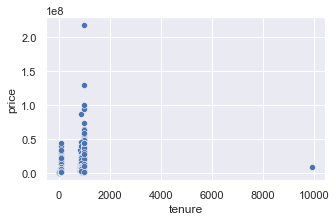

In [44]:
sns.set(font_scale=1)
plt.figure(figsize=(5,3))
sns.scatterplot(y = merged_house_tenure['price'], x = merged_house_tenure['tenure'])

In [45]:
merged_house_tenure['tenure'].max()

9944

In [46]:
merged_house_tenure['tenure'].idxmax()

2801

In [47]:
merged_house_tenure.loc[2801]

index                                    2801
project name       LANDED HOUSING DEVELOPMENT
street name                  WOODSVILLE CLOSE
type                                  Terrace
tenure                                   9944
postal district                          13.0
market segment                            RCR
type of sale                           Resale
no. of units                              2.0
price                               8400000.0
nett price                                  -
areasq                                 3601.0
type of area                             Land
floor level                                 -
unit price psf                         2333.0
date of sale                         Jul-2018
Name: 2801, dtype: object

In [48]:
merged_house_tenure['tenure'].replace({9944: 999}, inplace = True)

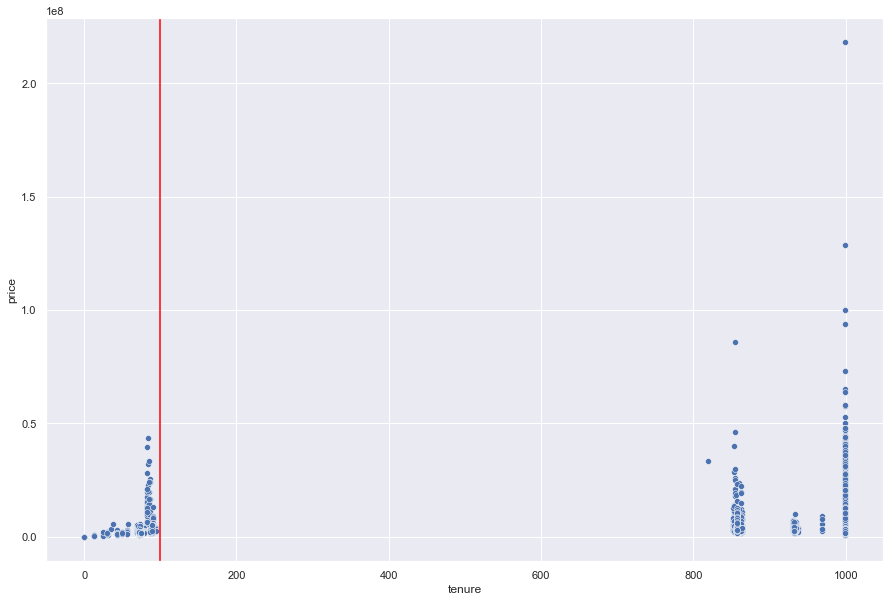

In [49]:
plt.figure(figsize=(15,10))
sns.scatterplot(y = merged_house_tenure['price'], x = merged_house_tenure['tenure'])
plt.axvline(x=99, color = 'red')

## In the graph above, we generally see an increasing trend for the prices as tenure increase up to the point of 99 years, as for freehodl onwards, the prices seems more of an outlier for the dataset

In [50]:
merged_house_tenure['type'].value_counts()

Terrace          5556
Semi-detached    2889
Detached         1283
Name: type, dtype: int64

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


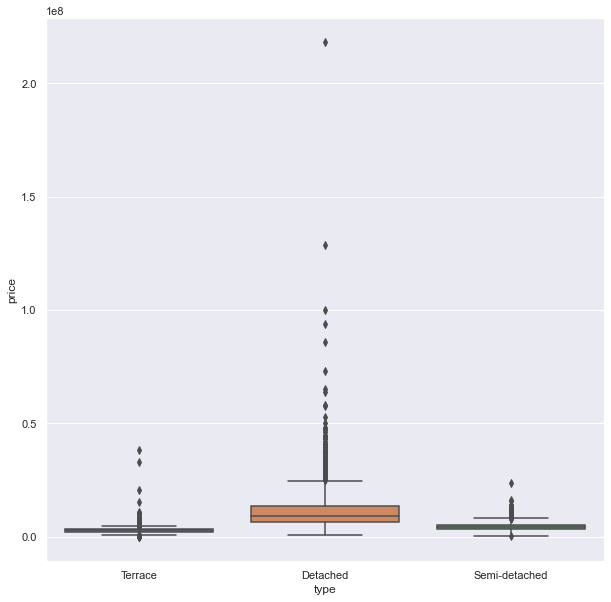

In [51]:
plt.figure(figsize =(10,10))
type_of_house = sns.boxplot('type', 'price', data = merged_house_tenure);

## Outlier is the high pricing for certain houses in the data set

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


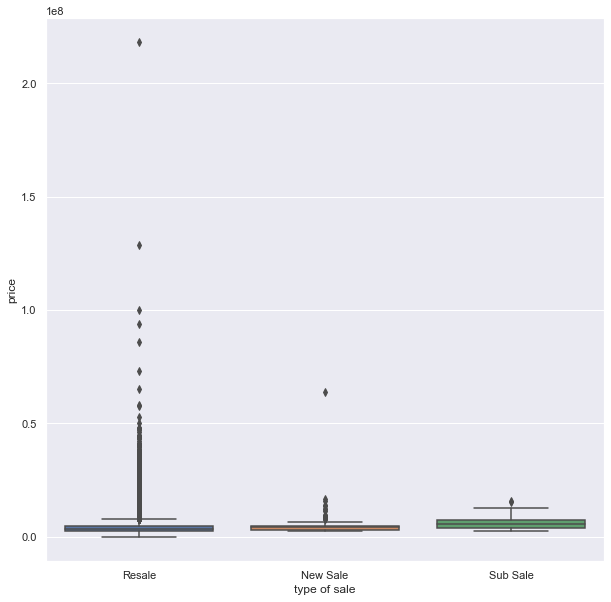

In [52]:
plt.figure(figsize =(10,10))
type_of_house = sns.boxplot('type of sale', 'price', data = merged_house_tenure);

## We can remove 2.5% of top and bottom outliers. A total of 5% of datasset to remove

In [53]:
merged_house_tenure.nlargest(10,'unit price psf', keep ='all')

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
528,528,LANDED HOUSING DEVELOPMENT,EMERALD HILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,10300000.0,-,1747.0,Land,-,5896.0,Jan-2021
853,853,LANDED HOUSING DEVELOPMENT,CAIRNHILL ROAD,Detached,999,9.0,CCR,Resale,1.0,100000000.0,-,19800.0,Land,-,5050.0,Jun-2018
461,461,LANDED HOUSING DEVELOPMENT,SAUNDERS ROAD,Terrace,999,9.0,CCR,Resale,1.0,10600000.0,-,2234.0,Land,-,4746.0,Apr-2021
497,497,EMERALD HILL CONSERVATION AREA,EMERALD HILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,6680000.0,-,1520.0,Land,-,4395.0,Mar-2021
639,639,LANDED HOUSING DEVELOPMENT,EMERALD HILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,5600000.0,-,1281.0,Land,-,4372.0,Jul-2020
330,330,EMERALD HILL CONSERVATION AREA,EMERALD HILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,5800000.0,-,1330.0,Land,-,4359.0,Aug-2021
498,498,EMERALD HILL CONSERVATION AREA,EMERALD HILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,8280000.0,-,1901.0,Land,-,4356.0,Feb-2021
621,621,CAIRNHILL CONSERVATION AREA,CAIRNHILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,8880000.0,-,2042.0,Land,-,4349.0,Aug-2020
345,345,LANDED HOUSING DEVELOPMENT,DEVONSHIRE ROAD,Terrace,999,9.0,CCR,Resale,1.0,6000000.0,-,1382.0,Land,-,4341.0,Aug-2021
719,719,EMERALD HILL CONSERVATION AREA,EMERALD HILL ROAD,Terrace,999,9.0,CCR,Resale,1.0,10500000.0,-,2442.0,Land,-,4299.0,Sep-2019


In [54]:
merged_house_tenure.shape

(9728, 16)

In [55]:
2.5/100 * 9728

243.20000000000002

## To remove 243 from top outlier and 243 from bottom outlier

In [56]:
merged_house_tenure = merged_house_tenure.sort_values(by = ['price'], ascending = False)

In [57]:
merged_house_tenure.head()

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
848,848,LANDED HOUSING DEVELOPMENT,NASSIM ROAD,Detached,999,10.0,CCR,Resale,2.0,218000000.0,-,66453.0,Land,-,3281.0,Jun-2018
479,479,LANDED HOUSING DEVELOPMENT,NASSIM ROAD,Detached,999,10.0,CCR,Resale,1.0,128800800.0,-,32160.0,Land,-,4005.0,Mar-2021
853,853,LANDED HOUSING DEVELOPMENT,CAIRNHILL ROAD,Detached,999,9.0,CCR,Resale,1.0,100000000.0,-,19800.0,Land,-,5050.0,Jun-2018
808,808,LANDED HOUSING DEVELOPMENT,DALVEY ROAD,Detached,999,10.0,CCR,Resale,1.0,93900000.0,-,52059.0,Land,-,1804.0,Sep-2018
363,363,QUEEN ASTRID PARK,QUEEN ASTRID PARK,Detached,854,10.0,CCR,Resale,1.0,86000000.0,-,31807.0,Land,-,2704.0,Jul-2021


In [58]:
merged_house_tenure.tail()

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
5273,5273,LANDED HOUSING DEVELOPMENT,JALAN CHEMPAKA KUNING,Terrace,13,16.0,OCR,Resale,1.0,330000.0,-,2354.0,Land,-,140.0,Dec-2019
2907,2907,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,63000.0,-,1911.0,Land,-,33.0,May-2018
3355,3355,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,50000.0,-,853.0,Land,-,59.0,Aug-2017
2805,2805,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,50000.0,-,725.0,Land,-,69.0,Jun-2018
2973,2973,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,40000.0,-,725.0,Land,-,55.0,Apr-2018


In [59]:
merged_house_tenure.drop(['index'], axis=1, inplace = True)

In [60]:
merged_house_tenure.head()

,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
848,LANDED HOUSING DEVELOPMENT,NASSIM ROAD,Detached,999,10.0,CCR,Resale,2.0,218000000.0,-,66453.0,Land,-,3281.0,Jun-2018
479,LANDED HOUSING DEVELOPMENT,NASSIM ROAD,Detached,999,10.0,CCR,Resale,1.0,128800800.0,-,32160.0,Land,-,4005.0,Mar-2021
853,LANDED HOUSING DEVELOPMENT,CAIRNHILL ROAD,Detached,999,9.0,CCR,Resale,1.0,100000000.0,-,19800.0,Land,-,5050.0,Jun-2018
808,LANDED HOUSING DEVELOPMENT,DALVEY ROAD,Detached,999,10.0,CCR,Resale,1.0,93900000.0,-,52059.0,Land,-,1804.0,Sep-2018
363,QUEEN ASTRID PARK,QUEEN ASTRID PARK,Detached,854,10.0,CCR,Resale,1.0,86000000.0,-,31807.0,Land,-,2704.0,Jul-2021


In [61]:
merged_house_tenure.reset_index(drop = False , inplace = True)

In [62]:
merged_house_tenure.head(3)

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
0,848,LANDED HOUSING DEVELOPMENT,NASSIM ROAD,Detached,999,10.0,CCR,Resale,2.0,218000000.0,-,66453.0,Land,-,3281.0,Jun-2018
1,479,LANDED HOUSING DEVELOPMENT,NASSIM ROAD,Detached,999,10.0,CCR,Resale,1.0,128800800.0,-,32160.0,Land,-,4005.0,Mar-2021
2,853,LANDED HOUSING DEVELOPMENT,CAIRNHILL ROAD,Detached,999,9.0,CCR,Resale,1.0,100000000.0,-,19800.0,Land,-,5050.0,Jun-2018


## To remove 243 rows form largest and smallest

In [63]:
biggest = merged_house_tenure.nlargest(242,'price', keep ='all')
smallest = merged_house_tenure.nsmallest(243,'price', keep ='all')

In [64]:
merged_house_tenure.iloc[242]

index                                    2893
project name       LANDED HOUSING DEVELOPMENT
street name                  TREVOSE CRESCENT
type                                 Detached
tenure                                    999
postal district                          11.0
market segment                            CCR
type of sale                           Resale
no. of units                              1.0
price                              16600000.0
nett price                                  -
areasq                                 8313.0
type of area                             Land
floor level                                 -
unit price psf                         1997.0
date of sale                         May-2018
Name: 242, dtype: object

## we can remove values >16600000

In [65]:
merged_house_tenure.tail(243)

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
9485,4366,LOYANG VILLAS,LOYANG RISE,Terrace,71,17.0,OCR,Resale,1.0,1480000.0,-,1615.0,Land,-,917.0,Mar-2021
9486,7763,VILLA VERDE,VERDE AVENUE,Terrace,75,23.0,OCR,Resale,1.0,1480000.0,-,1615.0,Land,-,917.0,Dec-2019
9487,4551,LOYANG VILLAS,LOYANG RISE,Terrace,71,17.0,OCR,Resale,1.0,1480000.0,-,1615.0,Land,-,917.0,Jan-2021
9488,7668,WESTVILLE,WESTWOOD ROAD,Terrace,72,22.0,OCR,Resale,1.0,1480000.0,-,2157.0,Land,-,686.0,Jul-2020
9489,8456,VILLA VERDE,VERDE GROVE,Terrace,75,23.0,OCR,Resale,1.0,1480000.0,-,1615.0,Land,-,917.0,Aug-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,5273,LANDED HOUSING DEVELOPMENT,JALAN CHEMPAKA KUNING,Terrace,13,16.0,OCR,Resale,1.0,330000.0,-,2354.0,Land,-,140.0,Dec-2019
9724,2907,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,63000.0,-,1911.0,Land,-,33.0,May-2018
9725,3355,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,50000.0,-,853.0,Land,-,59.0,Aug-2017
9726,2805,LANDED HOUSING DEVELOPMENT,LORONG 3 GEYLANG,Terrace,0,14.0,RCR,Resale,1.0,50000.0,-,725.0,Land,-,69.0,Jun-2018


In [66]:
merged_house_tenure.iloc[9485]

index                       4366
project name       LOYANG VILLAS
street name          LOYANG RISE
type                     Terrace
tenure                        71
postal district             17.0
market segment               OCR
type of sale              Resale
no. of units                 1.0
price                  1480000.0
nett price                     -
areasq                    1615.0
type of area                Land
floor level                    -
unit price psf             917.0
date of sale            Mar-2021
Name: 9485, dtype: object

## We can remove any values <1480000

## Removal of 5% of dataset due to outliers
## Removal of the top 243 and bottom 243 outliers, ranges from 1480000< data < 16600000

In [67]:
merged_house_clean = merged_house_tenure[merged_house_tenure['price'] < 16600000]

In [68]:
merged_house_clean = merged_house_clean[merged_house_clean['price'] > 1480000]

In [69]:
merged_house_clean.shape

(9240, 16)

In [70]:
merged_house_clean.head(2)

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
243,261,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,Detached,86,4.0,CCR,Resale,1.0,16550000.0,-,8940.0,Land,-,1851.0,Jun-2017
244,1287,LANDED HOUSING DEVELOPMENT,MERRYN ROAD,Detached,999,11.0,CCR,Resale,1.0,16550000.0,-,8878.0,Land,-,1864.0,Aug-2021


In [71]:
merged_house_clean.drop(['index'], axis=1, inplace = True)

In [72]:
merged_house_clean.head(2)

,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
243,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,Detached,86,4.0,CCR,Resale,1.0,16550000.0,-,8940.0,Land,-,1851.0,Jun-2017
244,LANDED HOUSING DEVELOPMENT,MERRYN ROAD,Detached,999,11.0,CCR,Resale,1.0,16550000.0,-,8878.0,Land,-,1864.0,Aug-2021


In [73]:
merged_house_clean.reset_index(drop = False , inplace = True)

In [74]:
merged_house_clean.head(2)

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
0,243,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,Detached,86,4.0,CCR,Resale,1.0,16550000.0,-,8940.0,Land,-,1851.0,Jun-2017
1,244,LANDED HOUSING DEVELOPMENT,MERRYN ROAD,Detached,999,11.0,CCR,Resale,1.0,16550000.0,-,8878.0,Land,-,1864.0,Aug-2021


In [75]:
merged_house_clean.drop(['index'], axis=1, inplace = True)

In [76]:
merged_house_clean.reset_index(drop = False , inplace = True)

In [77]:
merged_house_clean.head()

,index,project name,street name,type,tenure,postal district,market segment,type of sale,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale
0,0,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,Detached,86,4.0,CCR,Resale,1.0,16550000.0,-,8940.0,Land,-,1851.0,Jun-2017
1,1,LANDED HOUSING DEVELOPMENT,MERRYN ROAD,Detached,999,11.0,CCR,Resale,1.0,16550000.0,-,8878.0,Land,-,1864.0,Aug-2021
2,2,LANDED HOUSING DEVELOPMENT,COVE DRIVE,Detached,85,4.0,CCR,Resale,1.0,16500000.0,-,7281.0,Land,-,2266.0,Sep-2020
3,3,LANDED HOUSING DEVELOPMENT,WALTON ROAD,Detached,999,15.0,RCR,Resale,1.0,16300000.0,-,8673.0,Land,-,1879.0,Jul-2021
4,4,SANNY PARK,MERRYN ROAD,Detached,999,11.0,CCR,Resale,1.0,16300000.0,-,9064.0,Land,-,1798.0,Aug-2021


In [78]:
merged_house_clean.shape

(9240, 16)

In [79]:
merged_house_clean.to_csv('./dataset_asof_051121/merged_house_clean.csv', index=False)

# Looking at values after cleaning the dataset

(array([ 499.,  568.,  748.,  942., 1022.,  911.,  717.,  622.,  524.,
         430.,  283.,  254.,  187.,  183.,  157.,  126.,  108.,   92.,
          74.,   70.,   60.,   64.,   50.,   43.,   48.,   29.,   36.,
          30.,   23.,   40.,   20.,   27.,   22.,   28.,   21.,   16.,
          23.,   15.,   22.,   15.,   13.,   14.,    8.,   11.,   13.,
           6.,    9.,    7.,    5.,    5.]),
 array([ 1488888.  ,  1790110.24,  2091332.48,  2392554.72,  2693776.96,
         2994999.2 ,  3296221.44,  3597443.68,  3898665.92,  4199888.16,
         4501110.4 ,  4802332.64,  5103554.88,  5404777.12,  5705999.36,
         6007221.6 ,  6308443.84,  6609666.08,  6910888.32,  7212110.56,
         7513332.8 ,  7814555.04,  8115777.28,  8416999.52,  8718221.76,
         9019444.  ,  9320666.24,  9621888.48,  9923110.72, 10224332.96,
        10525555.2 , 10826777.44, 11127999.68, 11429221.92, 11730444.16,
        12031666.4 , 12332888.64, 12634110.88, 12935333.12, 13236555.36,
        13537777

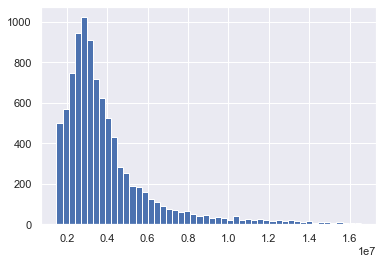

In [80]:
price = merged_house_clean['price']

plt.hist(price, bins =50)
# still skewed to left

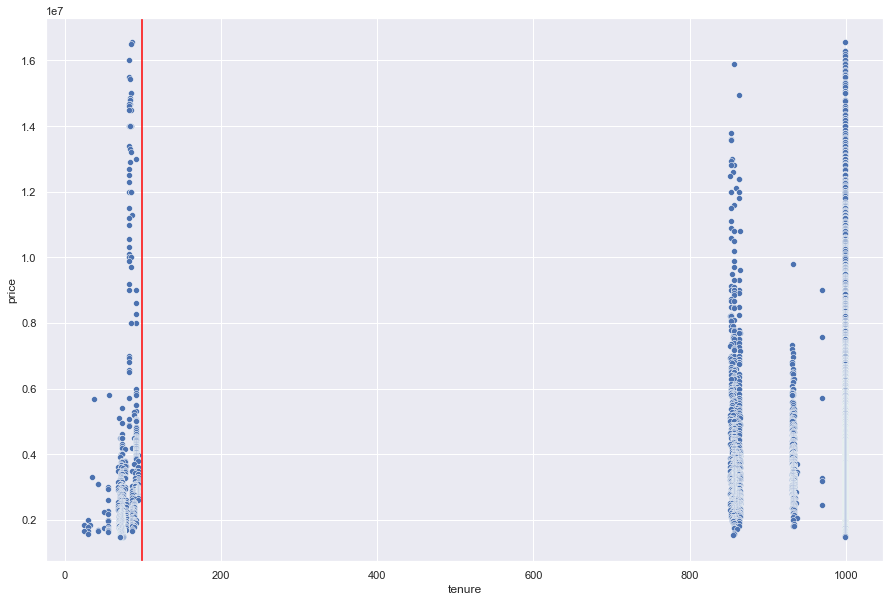

In [81]:
plt.figure(figsize=(15,10))
sns.scatterplot(y = merged_house_clean['price'], x = merged_house_clean['tenure'])
plt.axvline(x=99, color = 'red')

## This shows that house with tenure between 99 to 999 years may not have much differences in price after removing the outliers

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


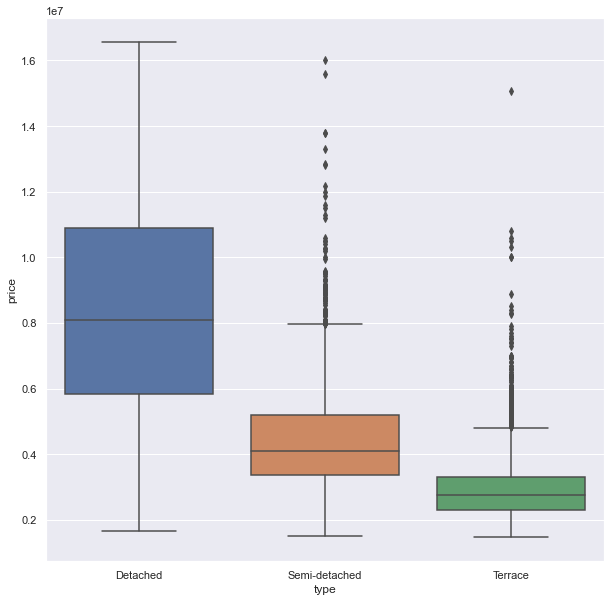

In [82]:
plt.figure(figsize =(10,10))
type_of_house = sns.boxplot('type', 'price', data = merged_house_clean);

C:\Users\jiexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


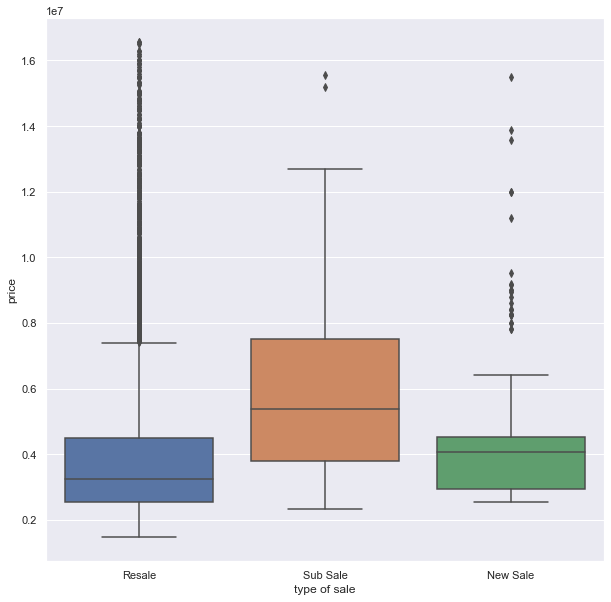

In [83]:
plt.figure(figsize =(10,10))
type_of_house = sns.boxplot('type of sale', 'price', data = merged_house_clean);

### To dummify certain features of the dataset, we will use merged_house_data to come out with the modelling

In [84]:
merged_house_data = pd.get_dummies(merged_house_clean, columns =['market segment', 'postal district', 'type', 'type of sale'])

In [85]:
merged_house_data.shape

(9240, 45)

In [86]:
merged_house_data.to_csv('./dataset_asof_051121/merged_house_data.csv', index=False)

# There is still a substantial amount of outliers in the emerged_house_data set, we will remove another 2.5% from the top and bottom, a total of 10 percent data removed

In [87]:
merged_house_data.head() 

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,...,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
0,0,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,16550000.0,-,8940.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
1,1,LANDED HOUSING DEVELOPMENT,MERRYN ROAD,999,1.0,16550000.0,-,8878.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
2,2,LANDED HOUSING DEVELOPMENT,COVE DRIVE,85,1.0,16500000.0,-,7281.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
3,3,LANDED HOUSING DEVELOPMENT,WALTON ROAD,999,1.0,16300000.0,-,8673.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
4,4,SANNY PARK,MERRYN ROAD,999,1.0,16300000.0,-,9064.0,Land,-,...,0,0,0,0,1,0,0,0,1,0


### Actual data shape was 9728 roles, we have removed 243 top and bottom rows(5%). We can remove another 243 rows from the top and bottom

In [88]:
merged_house_data.iloc[242]

index                                           242
project name             LANDED HOUSING DEVELOPMENT
street name                          GARLICK AVENUE
tenure                                          999
no. of units                                    1.0
price                                    11300000.0
nett price                                        -
areasq                                       9222.0
type of area                                   Land
floor level                                       -
unit price psf                               1225.0
date of sale                               Apr-2021
market segment_CCR                                1
market segment_OCR                                0
market segment_RCR                                0
postal district_2.0                               0
postal district_3.0                               0
postal district_4.0                               0
postal district_5.0                               0
postal distr

### Counting from bottom 9240 - 243

In [89]:
9240 - 243

8997

In [90]:
merged_house_data.iloc[8996]

index                             8996
project name              THE RIVERINA
street name              RIVERINA VIEW
tenure                              74
no. of units                       1.0
price                        1648000.0
nett price                           -
areasq                          1615.0
type of area                      Land
floor level                          -
unit price psf                  1021.0
date of sale                  Nov-2020
market segment_CCR                   0
market segment_OCR                   1
market segment_RCR                   0
postal district_2.0                  0
postal district_3.0                  0
postal district_4.0                  0
postal district_5.0                  0
postal district_8.0                  0
postal district_9.0                  0
postal district_10.0                 0
postal district_11.0                 0
postal district_12.0                 0
postal district_13.0                 0
postal district_14.0     

In [91]:
merged_house_10 = merged_house_data.copy(deep = True)

In [92]:
merged_house_10.shape

(9240, 45)

In [93]:
merged_house_10 = merged_house_10[merged_house_10['price'] < 11300000]

In [94]:
merged_house_10 = merged_house_10[merged_house_10['price'] > 1648000]

In [95]:
merged_house_10.shape

(8753, 45)

In [100]:
merged_house_10.head()

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,...,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
243,243,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,11288000.0,-,7011.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
244,244,LANDED HOUSING DEVELOPMENT,SUNSET PLACE,999,1.0,11237500.0,-,7749.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
245,245,LANDED HOUSING DEVELOPMENT,GROVE DRIVE,999,1.0,11200000.0,-,4170.0,Land,-,...,0,0,0,0,1,0,0,1,0,0
246,246,PARADISE ISLAND,PARADISE ISLAND,83,1.0,11200000.0,-,8633.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
247,247,LANDED HOUSING DEVELOPMENT,BRANKSOME ROAD,999,1.0,11200000.0,-,7129.0,Land,-,...,0,0,0,0,1,0,0,0,1,0


In [101]:
merged_house_10.drop(['index'], axis=1, inplace = True)

In [102]:
merged_house_10.head()

,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,...,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
243,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,11288000.0,-,7011.0,Land,-,1610.0,...,0,0,0,0,1,0,0,0,1,0
244,LANDED HOUSING DEVELOPMENT,SUNSET PLACE,999,1.0,11237500.0,-,7749.0,Land,-,1450.0,...,0,0,0,0,1,0,0,0,1,0
245,LANDED HOUSING DEVELOPMENT,GROVE DRIVE,999,1.0,11200000.0,-,4170.0,Land,-,2686.0,...,0,0,0,0,1,0,0,1,0,0
246,PARADISE ISLAND,PARADISE ISLAND,83,1.0,11200000.0,-,8633.0,Land,-,1297.0,...,0,0,0,0,1,0,0,0,1,0
247,LANDED HOUSING DEVELOPMENT,BRANKSOME ROAD,999,1.0,11200000.0,-,7129.0,Land,-,1571.0,...,0,0,0,0,1,0,0,0,1,0


In [103]:
merged_house_10.reset_index(drop = False , inplace = True)

In [105]:
merged_house_10.drop(['index'], axis=1, inplace = True)

In [107]:
merged_house_10.reset_index(drop = False , inplace = True)

In [110]:
merged_house_10.head()

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,...,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
0,0,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,11288000.0,-,7011.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
1,1,LANDED HOUSING DEVELOPMENT,SUNSET PLACE,999,1.0,11237500.0,-,7749.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
2,2,LANDED HOUSING DEVELOPMENT,GROVE DRIVE,999,1.0,11200000.0,-,4170.0,Land,-,...,0,0,0,0,1,0,0,1,0,0
3,3,PARADISE ISLAND,PARADISE ISLAND,83,1.0,11200000.0,-,8633.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
4,4,LANDED HOUSING DEVELOPMENT,BRANKSOME ROAD,999,1.0,11200000.0,-,7129.0,Land,-,...,0,0,0,0,1,0,0,0,1,0


# We will use the 10% reduction of data for modeeling as well

In [111]:
merged_house_10.to_csv('./dataset_asof_051121/merged_house_10.csv', index=False)